In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler

from util_funcs import (
    load_normalize_ibc_data,
    load_normalize_ipea_data,
    treat_candle_data,
)

sns.set_theme(style="whitegrid")

In [2]:
MACRO_FEATURES = [
    "macro_selic_change",
    "macro_ipca",
    "macro_ipca_surprise",
    "macro_dollar_ret",
    "macro_ibcbr_ret",
]

MACRO_FEATURES_TITLES = [
    "Variação da Selic (%)",
    "Nível do IPCA (pontos percentuais)",
    "Surpresa do IPCA (pontos percentuais)",
    "Variação do Dólar (%)",
    "Variação do IBC-Br (%)",
]

CANDLE_VARIABLES = ["OPEN", "HIGH", "LOW", "CLOSE"]

ASSETS_TO_IGNORE = ["KLBN11"]

In [3]:
candle_data = treat_candle_data("data/b3_candles_raw.csv")
df_selic = load_normalize_ipea_data("data/ipea_selic.csv")
df_ipca = load_normalize_ipea_data("data/ipea_ipca.csv")
df_ipca_exp = load_normalize_ipea_data("data/ipea_exp_ipca.csv")
df_dollar = load_normalize_ipea_data("data/ipea_camb.csv")
df_ibc = load_normalize_ibc_data("data/ibc_br.csv")

c:\Users\lucas\Documents\UFMG\2025-2\POC 1\b3-pattern-recon\util_funcs.py:28: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  raw_data = pd.read_csv(path, sep=";")
c:\Users\lucas\Documents\UFMG\2025-2\POC 1\b3-pattern-recon\util_funcs.py:47: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df["DATE"] = df["DATE"].dt.to_period("M").dt.to_timestamp("M")
c:\Users\lucas\Documents\UFMG\2025-2\POC 1\b3-pattern-recon\util_funcs.py:47: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df["DATE"] = df["DATE"].dt.to_period("M").dt.to_timestamp("M")
c:\Users\lucas\Documents\UFMG\2025-2\POC 1\b3-pattern-recon\util_funcs.py:47: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df["DATE"] = df["DATE"].dt.to_period("M").dt.to_timestamp("M")
c:\Users\lucas\Documents\UFMG\2025-2\POC 1\b3-pattern-recon\util_funcs.py:47

In [4]:
selic_monthly = df_selic["VALUE"].resample("ME").mean()
macro_selic_change = selic_monthly.diff()
macro_selic_change.name = "macro_selic_change"

macro_ipca = df_ipca["VALUE"].resample("ME").first()
macro_ipca.name = "macro_ipca"

ipca_exp_monthly = df_ipca_exp["VALUE"].resample("ME").first()
macro_ipca_surprise = macro_ipca - ipca_exp_monthly
macro_ipca_surprise.name = "macro_ipca_surprise"

dollar_monthly = df_dollar["VALUE"].resample("ME").last()
macro_dollar_ret = dollar_monthly.pct_change() * 100
macro_dollar_ret.name = "macro_dollar_ret"

ibc_monthly = df_ibc["IBC_HEADLINE"].resample("ME").first()
macro_ibcbr_ret = ibc_monthly.pct_change() * 100

macro_ibcbr_ret.name = "macro_ibcbr_ret"

In [5]:
# remove assets with less than 4 years of data
candle_data["YEAR"] = candle_data["TIMESTAMP"].dt.year
availability = candle_data[["NAME", "YEAR"]].drop_duplicates()
availability["has_data"] = 1
recent_assets = (
    availability["NAME"]
    .value_counts()[availability["NAME"].value_counts() < 4]
    .index.tolist()
)
candle_data = candle_data[~candle_data["NAME"].isin(recent_assets)].copy()
candle_data.drop(columns=["YEAR"], inplace=True)

# remove assets with less than 10k rows
asset_counts = candle_data["NAME"].value_counts()
small_assets = asset_counts[asset_counts < 10000].index.tolist()
candle_data = candle_data[~candle_data["NAME"].isin(small_assets)].copy()
data = candle_data.merge(
    macro_selic_change, left_on="TIMESTAMP", right_index=True, how="left"
)

In [6]:
if not pd.api.types.is_datetime64_any_dtype(candle_data["TIMESTAMP"]):
    candle_data["TIMESTAMP"] = pd.to_datetime(candle_data["TIMESTAMP"])

assets_monthly_returns = {}
for var in CANDLE_VARIABLES:
    assets_monthly_var = (
        candle_data.set_index("TIMESTAMP")
        .groupby("NAME")[var]
        .resample("ME")
        .last()
        .unstack(level=0)
    )
    assets_monthly_ret_var = assets_monthly_var.pct_change() * 100
    assets_monthly_ret_var["MARKET_INDEX"] = assets_monthly_ret_var.mean(axis=1)
    assets_monthly_returns[var] = assets_monthly_ret_var


macro_df = pd.concat(
    [
        macro_selic_change,
        macro_ipca,
        macro_ipca_surprise,
        macro_dollar_ret,
        macro_ibcbr_ret,
    ],
    axis=1,
)

C:\Users\lucas\AppData\Local\Temp\ipykernel_51472\2426828033.py:13: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  assets_monthly_ret_var = assets_monthly_var.pct_change() * 100
C:\Users\lucas\AppData\Local\Temp\ipykernel_51472\2426828033.py:13: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  assets_monthly_ret_var = assets_monthly_var.pct_change() * 100
C:\Users\lucas\AppData\Local\Temp\ipykernel_51472\2426828033.py:13: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to 

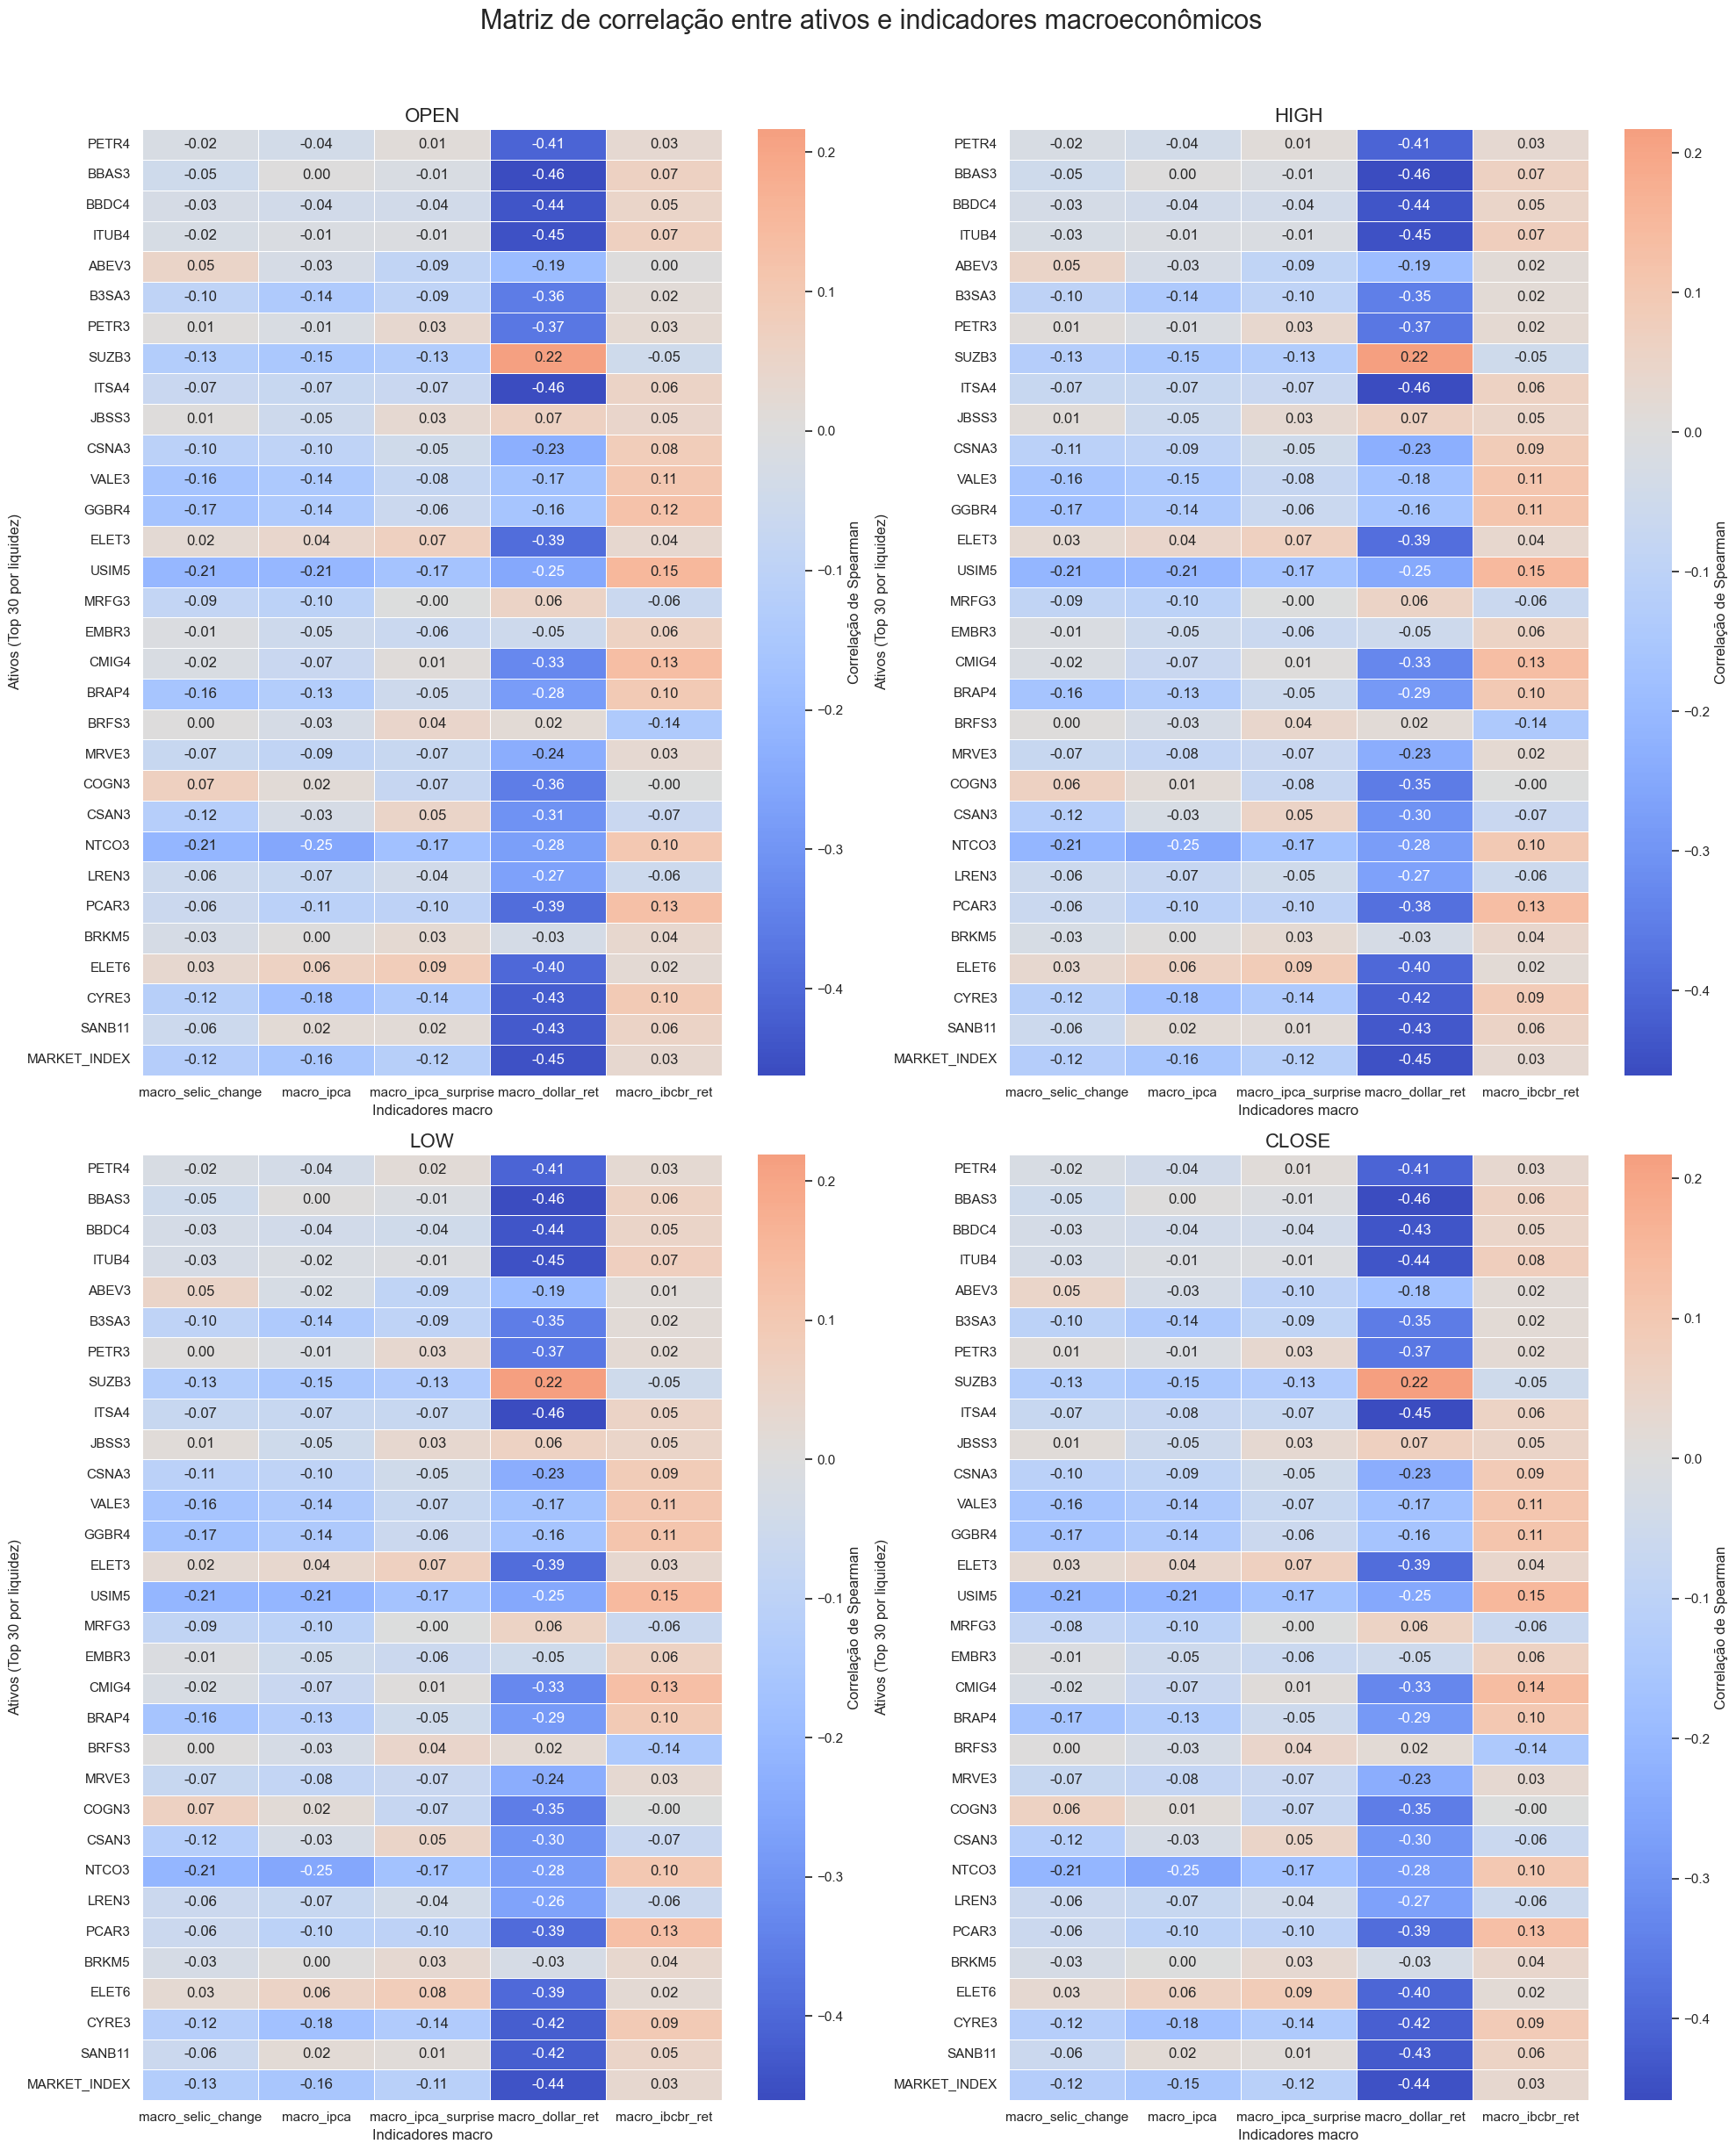

In [7]:
top_assets_names = candle_data["NAME"].value_counts().head(30).index.tolist()
top_assets_names.append("MARKET_INDEX")

assets_corr_results = {}
fig, axes = plt.subplots(2, 2, figsize=(20, 24))
axes = axes.flatten()
fig.tight_layout(pad=5.0)
fig.suptitle(
    "Matriz de correlação entre ativos e indicadores macroeconômicos",
    fontsize=22,
    y=1.02,
)

for var, ax in zip(CANDLE_VARIABLES, axes):
    master_df = assets_monthly_returns[var].join(macro_df, how="inner")

    available_assets = [c for c in top_assets_names if c in master_df.columns]

    corr_matrix = master_df.corr(method="spearman")

    assets_corr_results[var] = corr_matrix

    corr_assets_macro = corr_matrix.loc[available_assets, MACRO_FEATURES]

    sns.heatmap(
        corr_assets_macro,
        annot=True,
        cmap="coolwarm",
        center=0,
        fmt=".2f",
        linewidths=0.5,
        cbar_kws={"label": "Correlação de Spearman"},
        ax=ax,
    )
    ax.set_title(var, fontsize=16)
    ax.set_xlabel("Indicadores macro", fontsize=12)
    ax.set_ylabel("Ativos (Top 30 por liquidez)", fontsize=12)
plt.tight_layout()
plt.show()

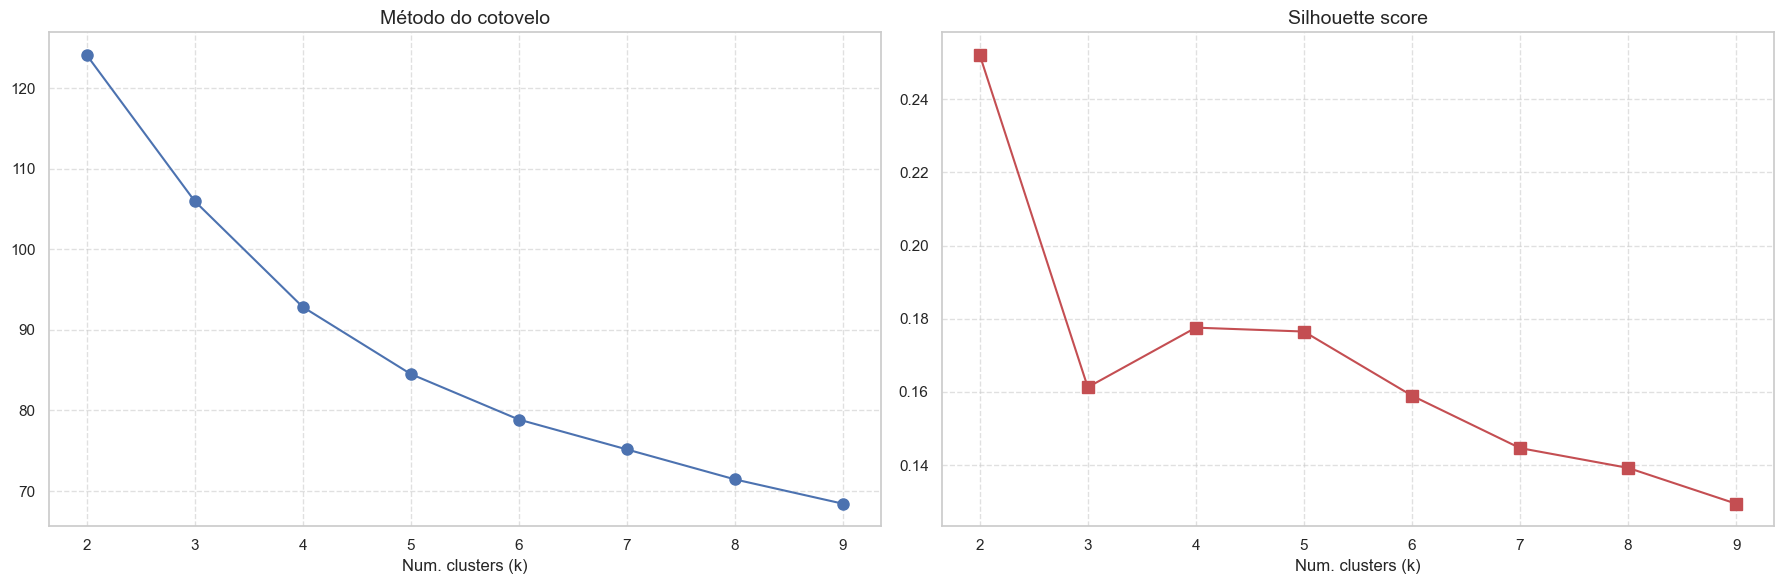

In [8]:
cols_to_drop = MACRO_FEATURES + ASSETS_TO_IGNORE + ["MARKET_INDEX"]
behav_corr_matrix = (
    assets_corr_results["CLOSE"]
    .drop(columns=cols_to_drop, errors="ignore")
    .drop(index=cols_to_drop, errors="ignore")
)

behav_corr_matrix = behav_corr_matrix.fillna(0)

k_range = range(2, 10)
inertias = []
silhouette_scores = []

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(behav_corr_matrix)

    inertias.append(kmeans.inertia_)

    score = silhouette_score(behav_corr_matrix, labels)
    silhouette_scores.append(score)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))

ax1.plot(k_range, inertias, "bo-", markersize=8)
ax1.set_title("Método do cotovelo", fontsize=14)
ax1.set_xlabel("Num. clusters (k)", fontsize=12)
ax1.grid(True, linestyle="--", alpha=0.6)

ax2.plot(k_range, silhouette_scores, "rs-", markersize=8)
ax2.set_title("Silhouette score", fontsize=14)
ax2.set_xlabel("Num. clusters (k)", fontsize=12)
ax2.grid(True, linestyle="--", alpha=0.6)

plt.tight_layout()
plt.show()

C:\Users\lucas\AppData\Local\Temp\ipykernel_51472\3263407719.py:33: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  df_viz.PC1[i] + 0.08,
C:\Users\lucas\AppData\Local\Temp\ipykernel_51472\3263407719.py:34: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  df_viz.PC2[i] - 0.01,


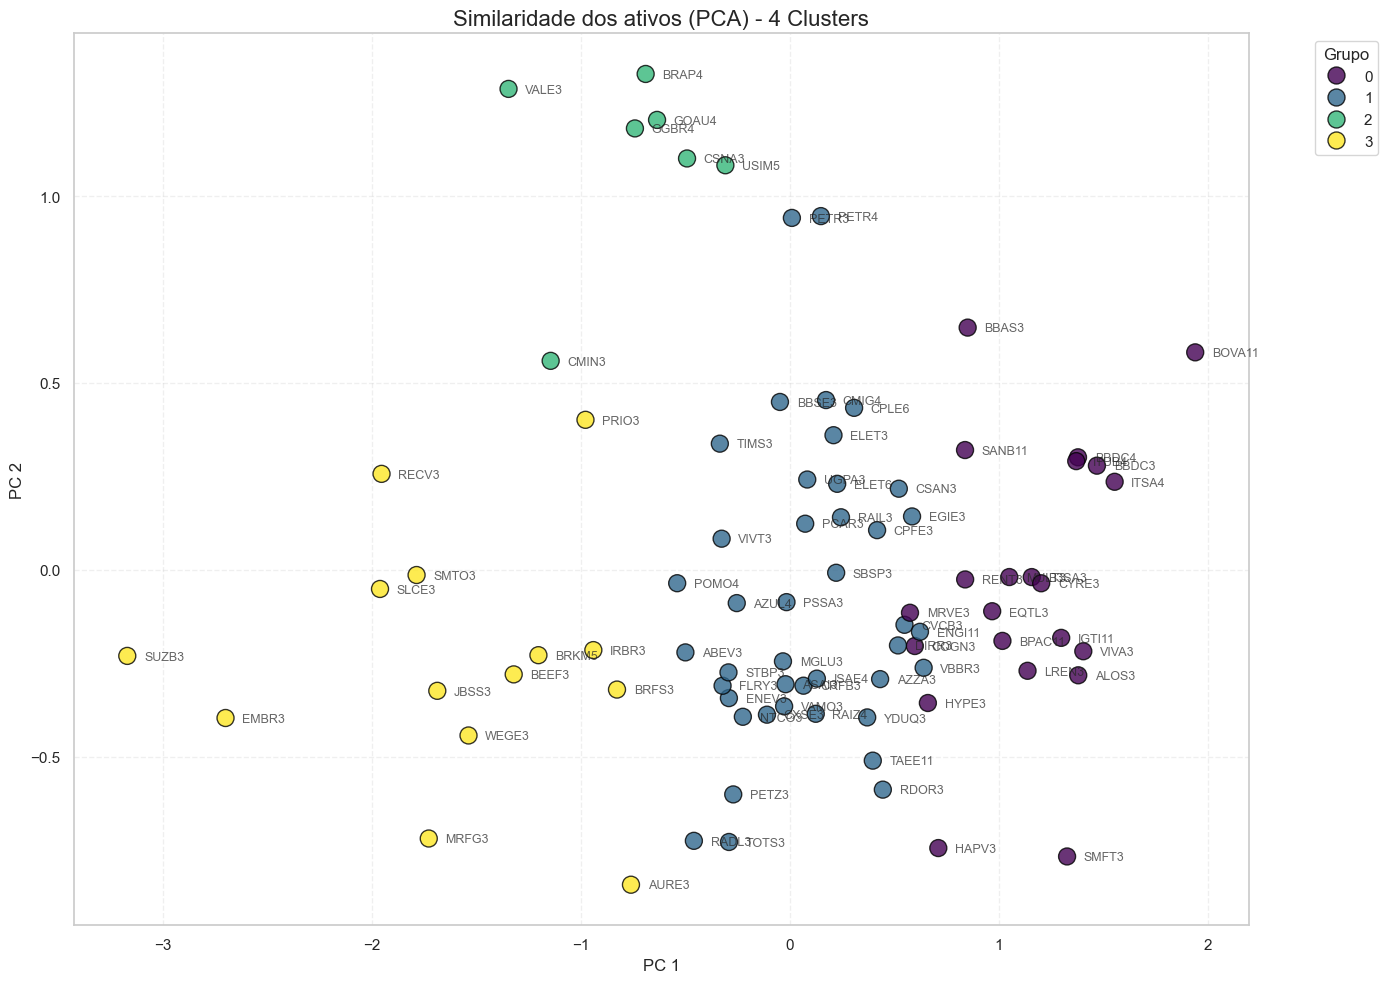

In [9]:
k_best = 4

mon_behav = KMeans(n_clusters=k_best, random_state=42, n_init=10)
mon_behav_clusters = mon_behav.fit_predict(behav_corr_matrix)

df_clusters_ohlc = pd.DataFrame()
df_clusters_ohlc["Ativo"] = behav_corr_matrix.index
df_clusters_ohlc["Cluster_OHLC"] = mon_behav_clusters

pca = PCA(n_components=2)
pca_components = pca.fit_transform(behav_corr_matrix)

df_viz = pd.DataFrame(
    data=pca_components, columns=["PC1", "PC2"], index=behav_corr_matrix.index
)
df_viz["Cluster"] = mon_behav_clusters

plt.figure(figsize=(14, 10))

sns.scatterplot(
    data=df_viz,
    x="PC1",
    y="PC2",
    hue="Cluster",
    palette="viridis",
    s=150,
    alpha=0.8,
    edgecolor="black",
)

for i in range(df_viz.shape[0]):
    plt.text(
        df_viz.PC1[i] + 0.08,
        df_viz.PC2[i] - 0.01,
        df_viz.index[i],
        fontsize=9,
        alpha=0.7,
    )

plt.title(f"Similaridade dos ativos (PCA) - {k_best} Clusters", fontsize=16)
plt.xlabel("PC 1", fontsize=12)
plt.ylabel("PC 2", fontsize=12)
plt.legend(title="Grupo", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.grid(True, linestyle="--", alpha=0.3)
plt.tight_layout()
plt.show()

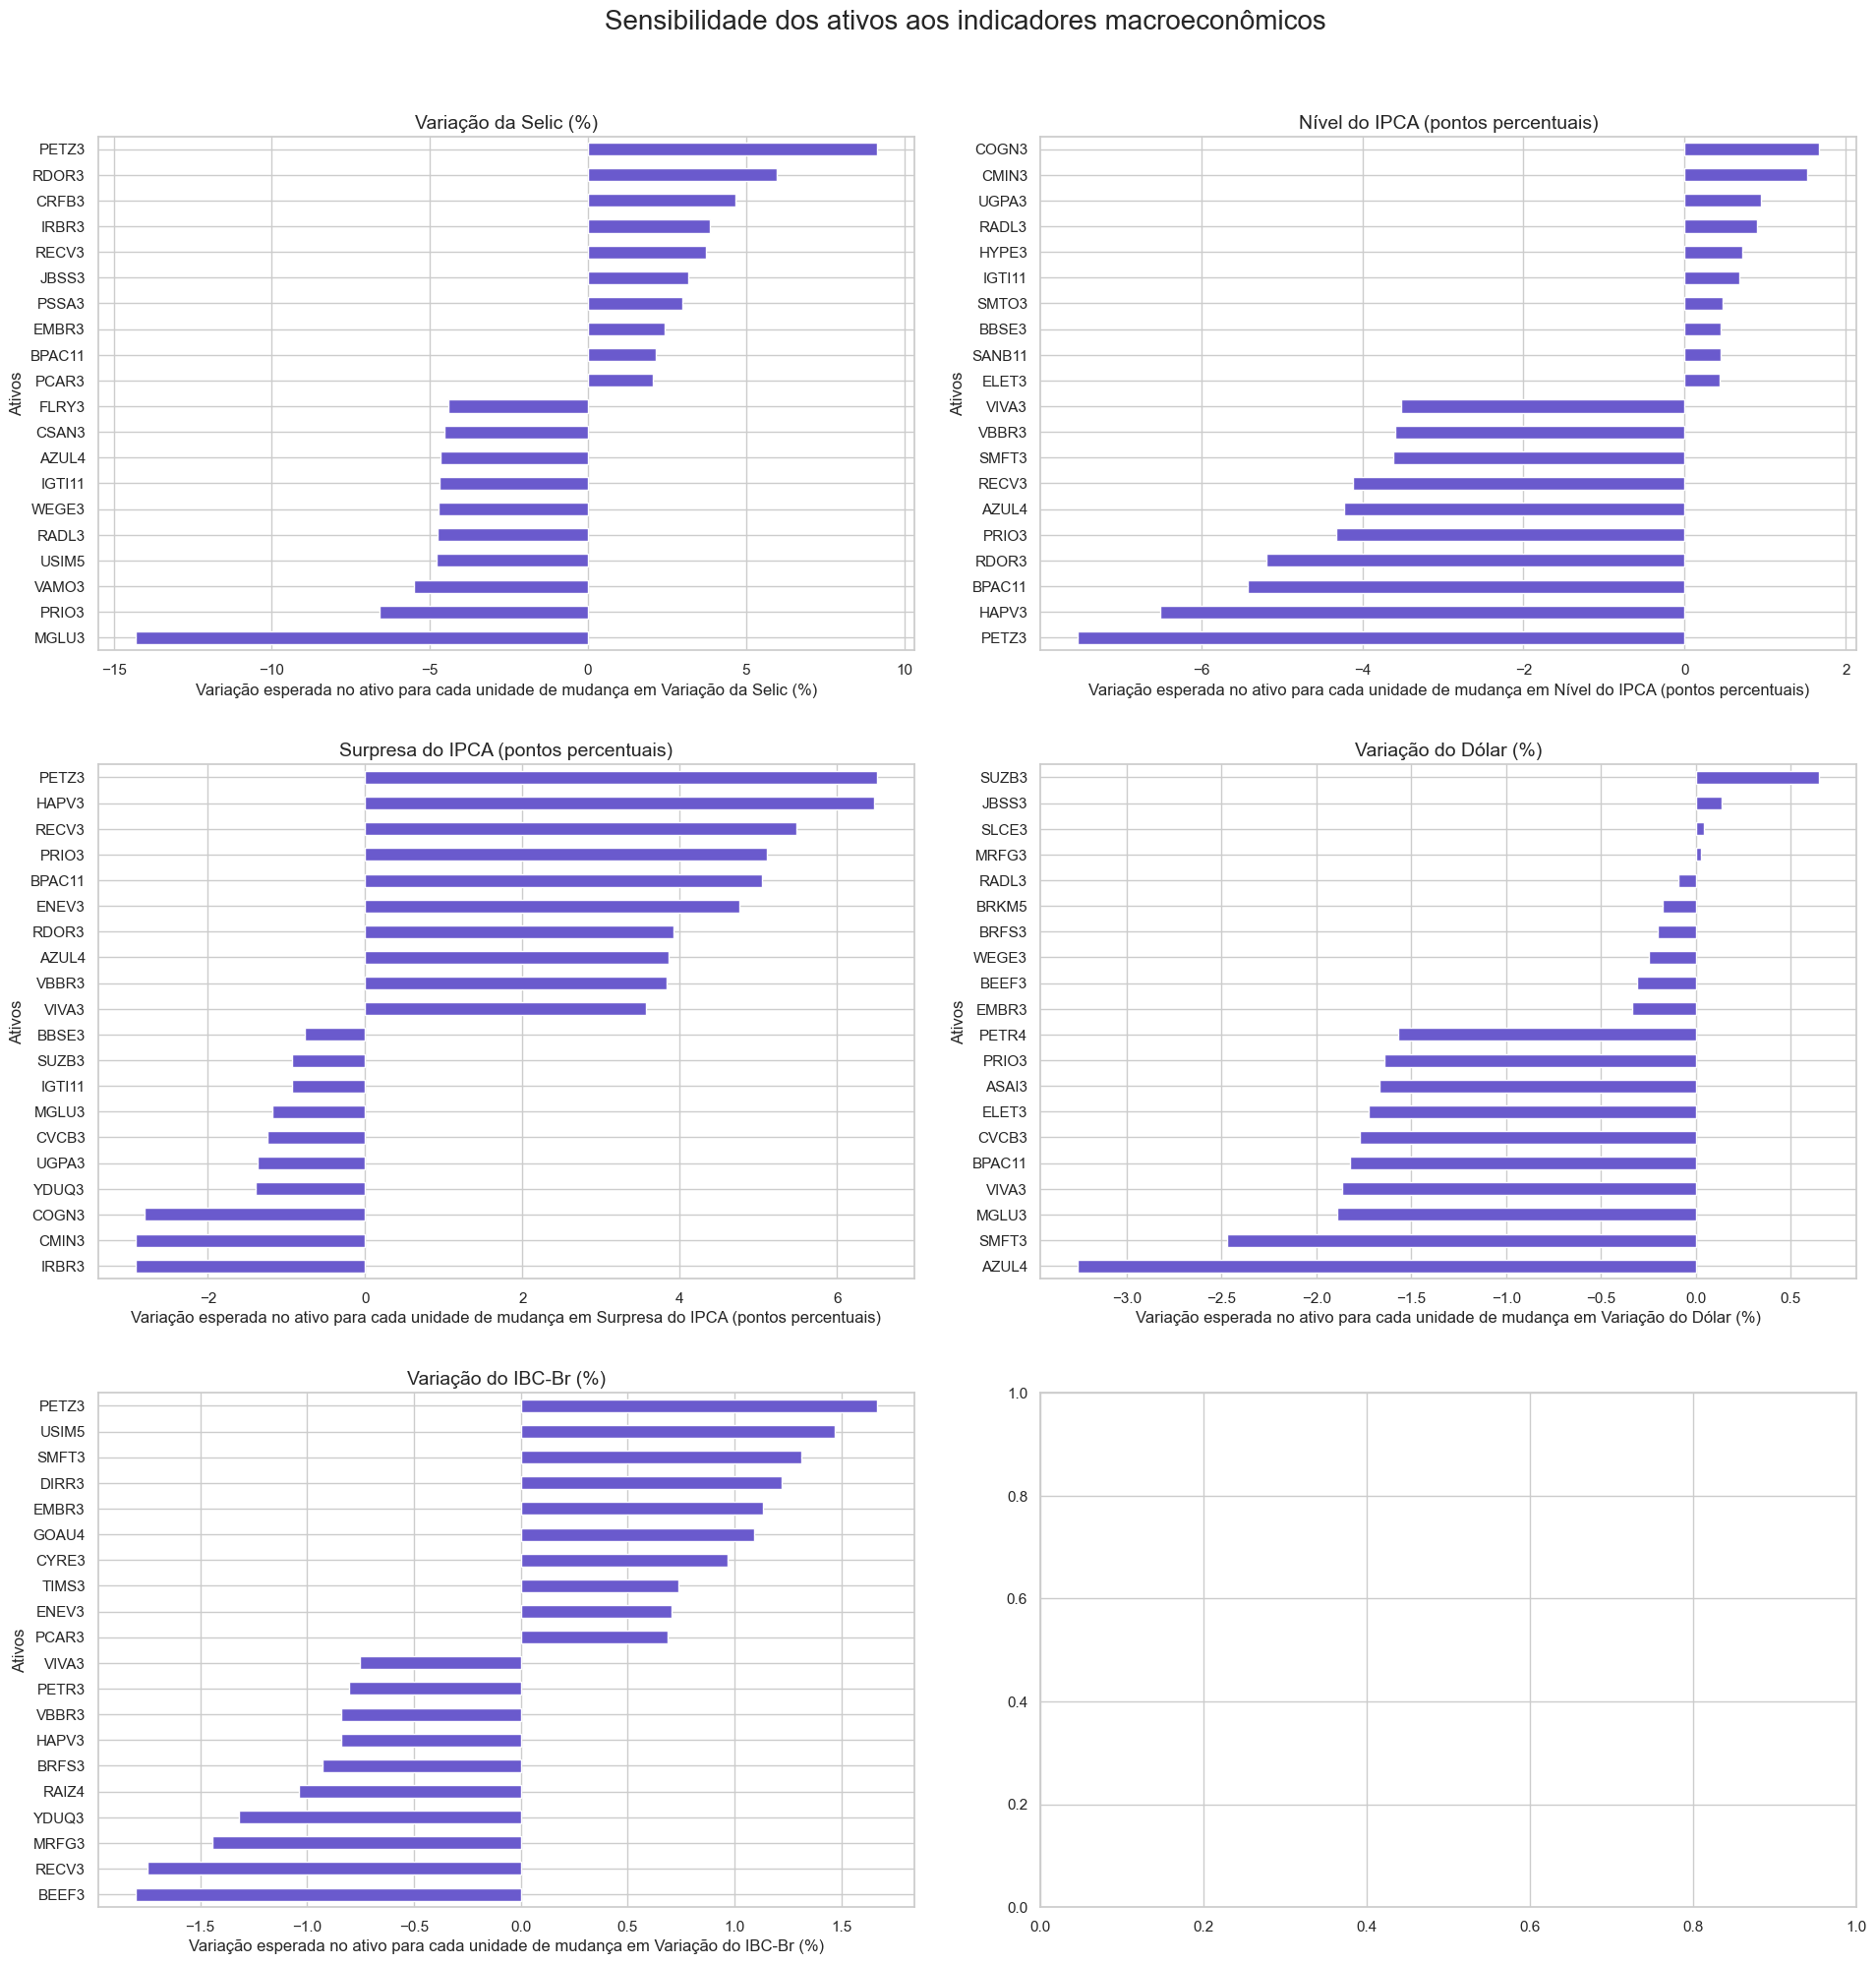

In [10]:
master_df = assets_monthly_returns["CLOSE"].join(macro_df, how="inner")

targets = [c for c in master_df.columns if c not in cols_to_drop]

asset_betas = []

for asset in targets:
    temp_df = master_df[MACRO_FEATURES + [asset]].dropna()

    if len(temp_df) < 12:
        continue

    X = temp_df[MACRO_FEATURES]
    y = temp_df[asset]

    model = LinearRegression()
    model.fit(X, y)

    result = {
        "Ativo": asset,
        "R2": model.score(X, y),
        "Obs": len(temp_df),
    }

    for feature, coef in zip(MACRO_FEATURES, model.coef_):
        result[feature] = coef

    asset_betas.append(result)

betas_df = pd.DataFrame(asset_betas).set_index("Ativo")

fig, axes = plt.subplots(3, 2, figsize=(20, 20))
axes = axes.flatten()
fig.tight_layout(pad=5.0)
fig.suptitle(
    "Sensibilidade dos ativos aos indicadores macroeconômicos",
    fontsize=20,
    y=1.02,
)
for feature, title, ax in zip(MACRO_FEATURES, MACRO_FEATURES_TITLES, axes):
    top_feature = betas_df[feature].sort_values(ascending=False).head(10)
    bottom_feature = betas_df[feature].sort_values(ascending=True).head(10)

    pd.concat([top_feature, bottom_feature]).sort_values().plot(
        kind="barh", color="slateblue", ax=ax
    )

    ax.set_title(f"{title}", fontsize=14)
    ax.set_xlabel(
        f"Variação esperada no ativo para cada unidade de mudança em {title}",
        fontsize=12,
    )
    ax.set_xscale("linear")
    ax.set_ylabel("Ativos", fontsize=12)

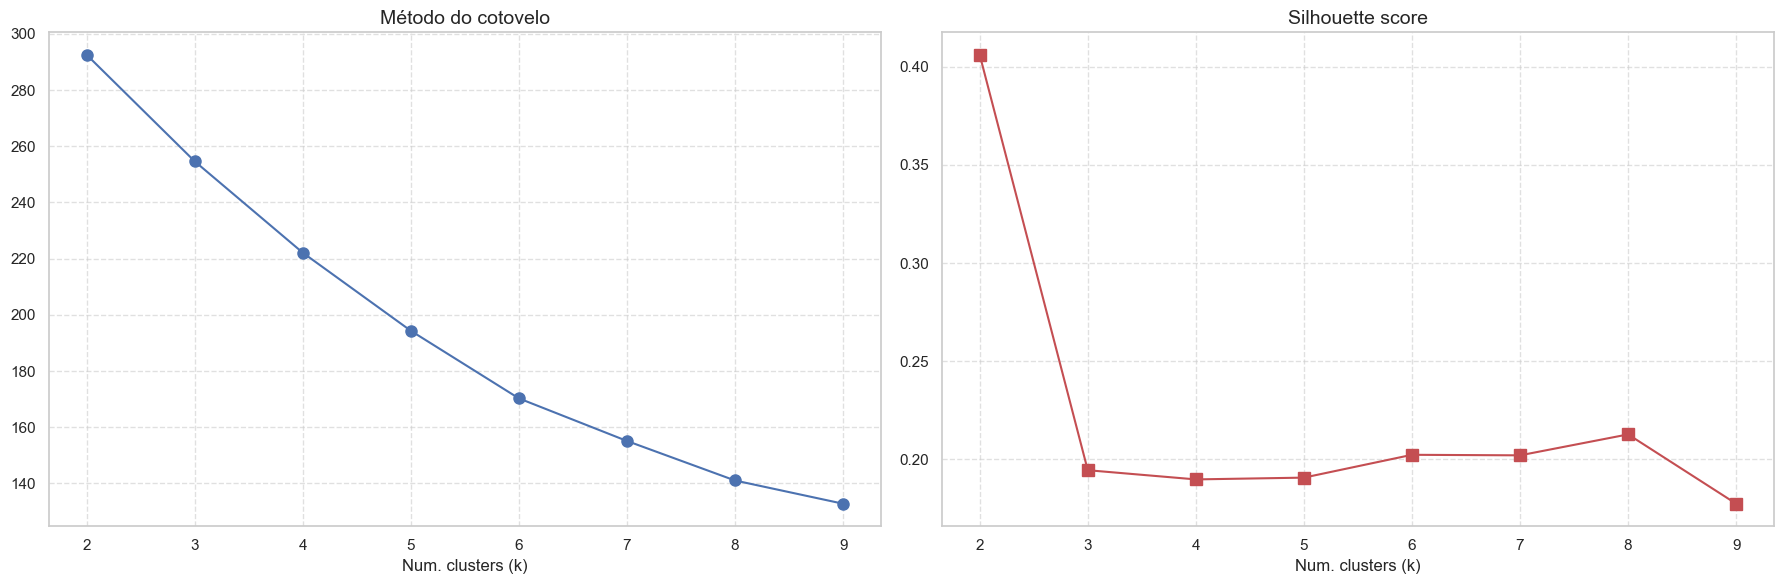

In [11]:
beta_cols = [c for c in betas_df.columns if c.startswith("macro_")]
X_betas = betas_df[beta_cols].copy()

scaler_macro = StandardScaler()
X_betas_scaled = scaler_macro.fit_transform(X_betas)

inertias = []
silhouette_scores = []

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(X_betas_scaled)

    inertias.append(kmeans.inertia_)

    score = silhouette_score(X_betas_scaled, labels)
    silhouette_scores.append(score)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))

ax1.plot(k_range, inertias, "bo-", markersize=8)
ax1.set_title("Método do cotovelo", fontsize=14)
ax1.set_xlabel("Num. clusters (k)", fontsize=12)
ax1.grid(True, linestyle="--", alpha=0.6)

ax2.plot(k_range, silhouette_scores, "rs-", markersize=8)
ax2.set_title("Silhouette score", fontsize=14)
ax2.set_xlabel("Num. clusters (k)", fontsize=12)
ax2.grid(True, linestyle="--", alpha=0.6)

plt.tight_layout()
plt.show()

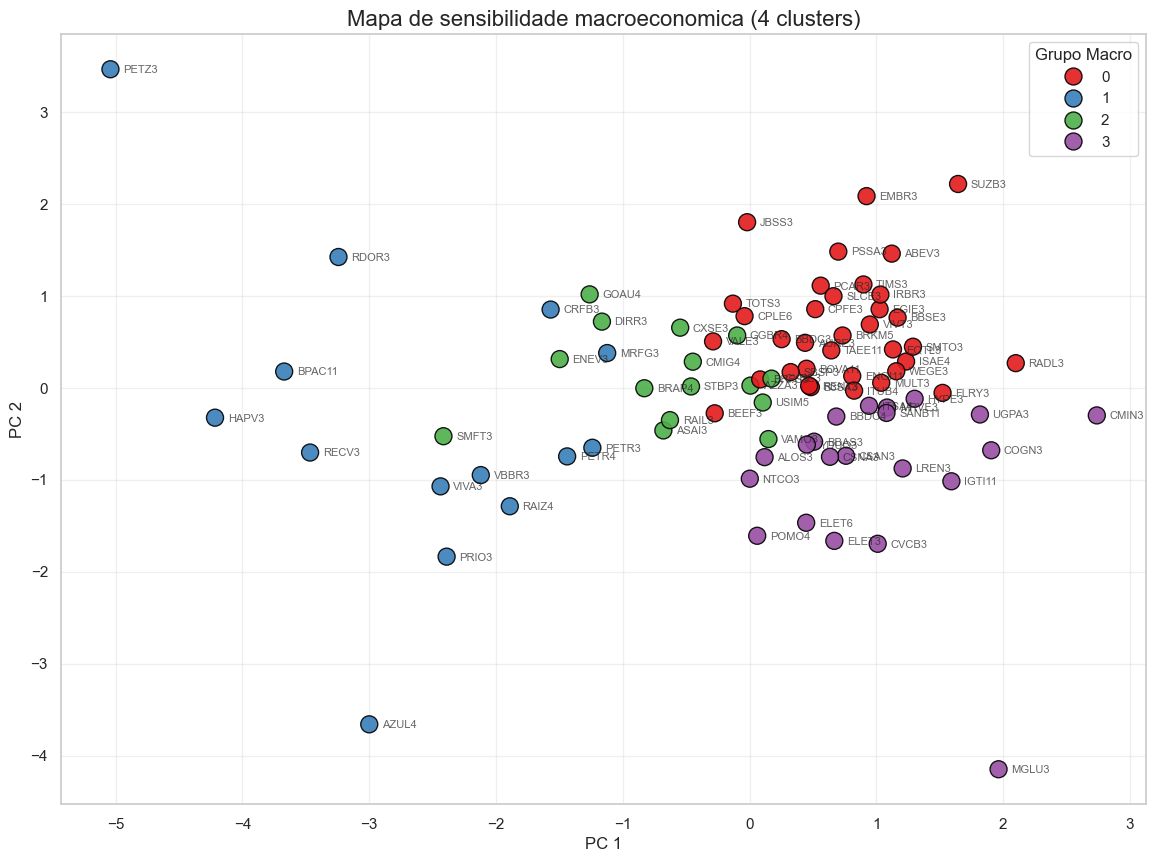

In [12]:
best_k_macro = 4

kmeans_macro = KMeans(n_clusters=best_k_macro, random_state=42, n_init=10)
macro_clusters = kmeans_macro.fit_predict(X_betas_scaled)

betas_df["Cluster_Macro"] = macro_clusters

pca_macro = PCA(n_components=2)
components_macro = pca_macro.fit_transform(X_betas_scaled)

plt.figure(figsize=(14, 10))
sns.scatterplot(
    x=components_macro[:, 0],
    y=components_macro[:, 1],
    hue=betas_df["Cluster_Macro"],
    palette="Set1",
    s=150,
    alpha=0.9,
    edgecolor="black",
)

for i, txt in enumerate(betas_df.index):
    plt.annotate(
        txt,
        (components_macro[i, 0] + 0.1, components_macro[i, 1] - 0.04),
        fontsize=8,
        alpha=0.7,
    )

plt.title(
    f"Mapa de sensibilidade macroeconomica ({best_k_macro} clusters)", fontsize=16
)
plt.xlabel("PC 1")
plt.ylabel("PC 2")
plt.legend(title="Grupo Macro")
plt.grid(True, alpha=0.3)
plt.show()

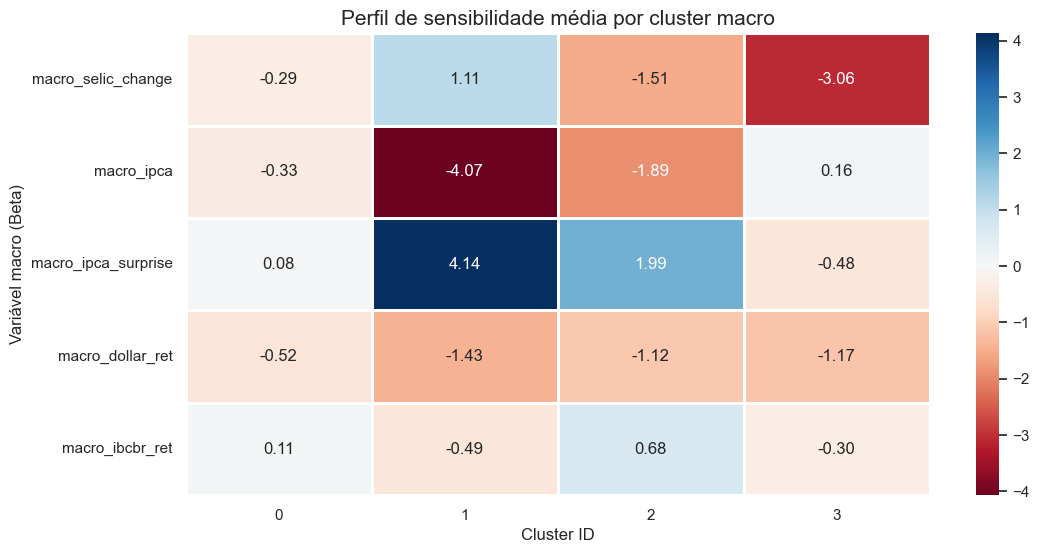

In [13]:
cluster_profiles = betas_df.groupby("Cluster_Macro")[beta_cols].mean()


plt.figure(figsize=(12, 6))
sns.heatmap(
    cluster_profiles.T,
    cmap="RdBu",
    center=0,
    annot=True,
    fmt=".2f",
    linewidths=1,
)
plt.title("Perfil de sensibilidade média por cluster macro", fontsize=15)
plt.xlabel("Cluster ID")
plt.ylabel("Variável macro (Beta)")
plt.show()